# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
n_all_samples = np.shape(U1)[0]
n_used_samples = 100
n_burn_in = 20
n_samples= 150
n_acquisition = 100
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
n_exp_runs = 10
n_samples_to_remember = 20
print(n_used_samples)
print(np.shape(X0_psd.iloc[0:n_used_samples]))
print(np.shape(U1.iloc[0:n_used_samples]), np.shape(X1[0:n_used_samples,:]))
# print(U1)
# print(X1)

100
(100, 1)
(100, 2) (100, 1)


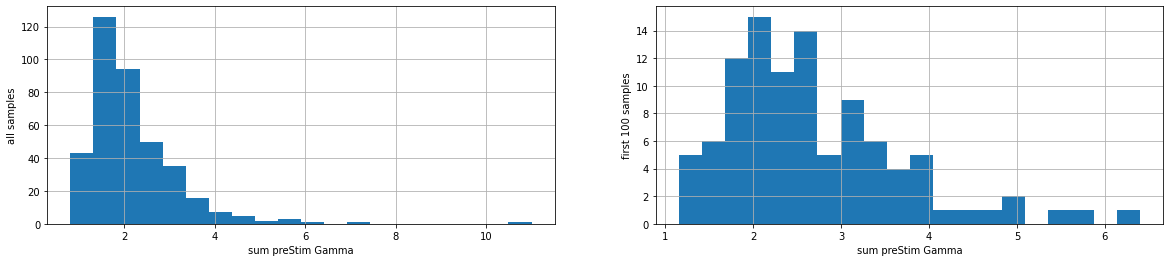

In [7]:
# histogram of raw PSD of preStim gamma
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.hist(X0_psd, bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel("all samples")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.hist(X0_psd[0:n_used_samples], bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel(f"first {'{0:d}'.format(n_used_samples)} samples")
plt.grid(visible=True)
plt.show();

In [8]:
# Balancing Anastesia and Awake samples
# input_data
U1_X0 = U1.join(X0_psd)

U1_X0_sel = U1_X0[0:n_used_samples]
X1_sel = X1[0:n_used_samples]

def apply_data_mask(U1_X0, X1):
    # n_used_samples = 100; 
    scale = .1
    f_thresh = 25; g_thresh = 3
    U1_X0_sel = U1_X0[0:n_used_samples]
    X1_sel = np.squeeze(X1[0:n_used_samples])
    
    X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
    # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
    sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
    #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
    X1_sel = np.multiply(X1_sel,sc)
    #display( np.multiply(X1_sel[X1_thresh],sc))
    X1_sel = X1_sel.reshape(-1,1)
    
    return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = apply_data_mask(U1_X0, X1)
display(U1_X0_sel)
display(np.shape(X1_sel))

,Stim_1,Stim_2,sum_preStim_gamma
0,17,30,3.266571
1,42,40,2.425945
2,35,30,3.117866
3,23,50,2.868627
4,42,50,3.521665
...,...,...,...
95,35,20,3.700448
96,17,20,1.337936
97,5,10,1.672055
98,17,30,3.179625


(100, 1)

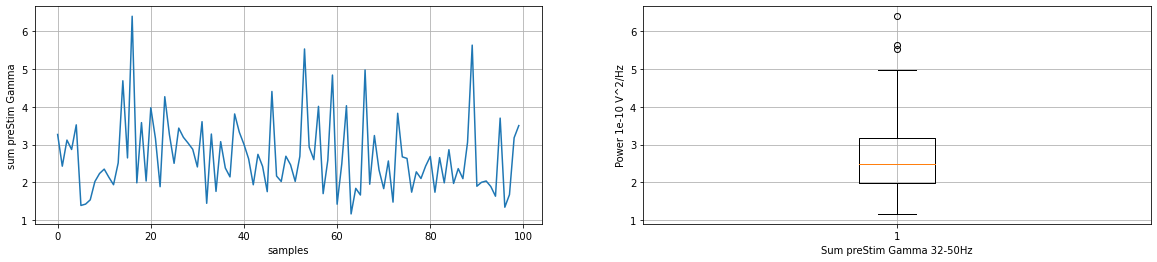

In [9]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(0, n_used_samples), U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("Sum preStim Gamma 32-50Hz")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.grid(visible=True)

plt.show();

In [10]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
first_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.25)
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.75)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-first_quartile_sum_preStim_gamma)/half_n_samples,6)
# hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
# hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
#                                                                      min_sum_preStim_gamma, -step_size)
hill_sum_preStim_gamma[0:half_n_samples] = np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.flip(np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples))

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 2.5742740008887974
[1.52262311 1.54408538 1.56554764] (100,)


In [11]:
X0_psd_sampled = X0_psd.iloc[0:n_used_samples]
display(X0_psd_sampled['sum_preStim_gamma'])
display(U1_X0_sel['sum_preStim_gamma'])

0     3.266571
1     2.425945
2     3.117866
3     2.868627
4     3.521665
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 100, dtype: float64

0     3.266571
1     2.425945
2     3.117866
3     2.868627
4     3.521665
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 100, dtype: float64

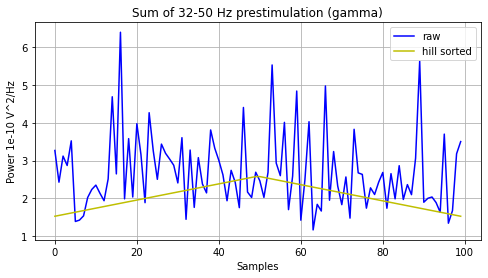

In [12]:
fig = plt.figure(figsize=(8,4));
# plt.plot(np.arange(0, n_used_samples), X0_psd_sampled['sum_preStim_gamma'], color='g');
plt.plot(np.arange(0, n_acquisition), U1_X0_sel['sum_preStim_gamma'][0:n_acquisition], color='b');

plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma, color='y');
plt.xlabel("Samples")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.legend(['raw', 'hill sorted'])
plt.title("Sum of 32-50 Hz prestimulation (gamma)")
plt.grid(visible=True)

In [13]:
print('freq, amplitude and preStim gamma used are: \n', U1_X0_sel[0:4])

freq, amplitude and preStim gamma used are: 
    Stim_1  Stim_2  sum_preStim_gamma
0      17      30           3.266571
1      42      40           2.425945
2      35      30           3.117866
3      23      50           2.868627


In [14]:
print(np.shape(U1_X0_sel))

(100, 3)


## 1.2 First BaO Model is trained on all of the dataset

In [15]:
ker_BaO = GPy.kern.RBF(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
# GPy.kern.Matern52(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [16]:
slice_dim = 1
ylabel='Predicted Gamma'

#### 1.2.1: The first model uses sum_preStim_gamma.

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c9228b0610>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c9228b0a30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0008   4.987731e+02   9.292211e+01 
    00s45  0022   3.242766e+02   8.815532e-01 
Runtime:     00s45
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926919be0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c92690aa90>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926a269d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c926a0e8b0>]}

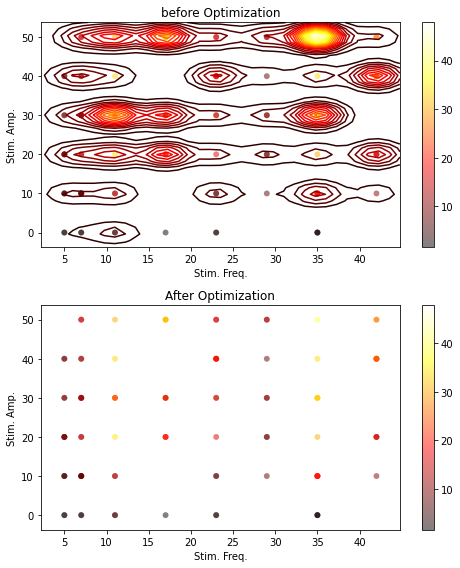

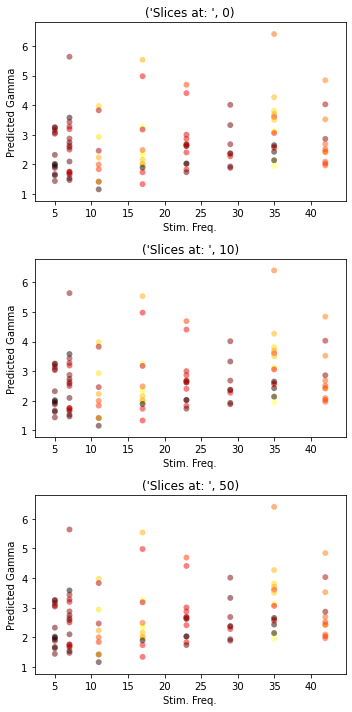

In [17]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0_sel,X1_sel,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [18]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [19]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [20]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [21]:
ker_BaO_AF = GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
# GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0006   2.726962e+02   2.843124e+02 
    00s19  0007   2.147164e+02   9.035514e+01 
    01s17  0049   7.543287e+01   4.601197e-11 
Runtime:     01s17
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926b335e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c926b0a0d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c9222af640>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2c9222afac0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2c922057460>]}

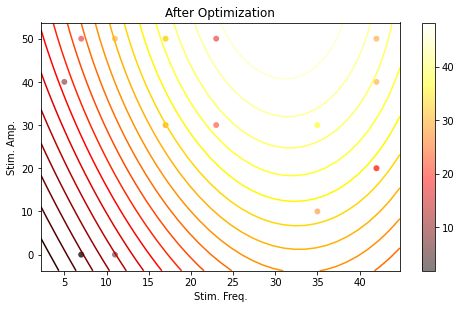

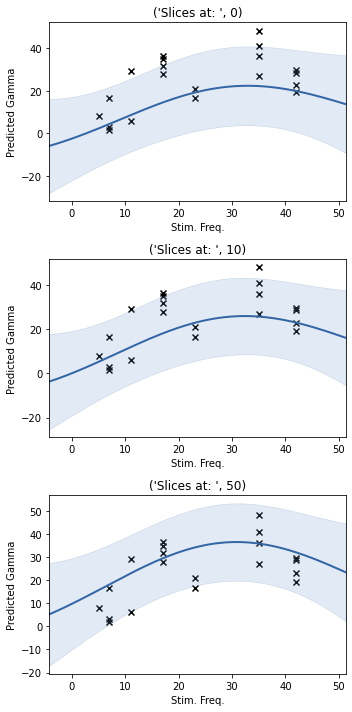

In [22]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [23]:
rand_freq_1d = np.random.choice([5, 7, 11, 17, 23, 29, 35, 42], size=(50))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted, np.shape(rand_freq_1d_sorted))
rand_amp_1d = np.random.choice([10, 20, 30, 40, 50], size=(50))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))
X_grid_mesh = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)
print(np.shape(X_grid))

[ 5  5  5  7  7  7  7  7  7 11 11 11 11 11 11 17 17 17 17 23 23 23 23 29
 29 29 29 29 29 29 29 29 29 29 29 35 35 35 35 35 35 35 35 42 42 42 42 42
 42 42] (50,)
[10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 30 30 30 30 30 30 30
 30 30 30 30 30 40 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50
 50 50] (50,)
(2500, 2)


In [24]:
# print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

# testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
# print(np.shape(testX_BaO))
# testX = np.transpose(testX_BaO)
testX = X_grid
print(np.shape(testX))

(2500, 2)


In [25]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)

    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
    
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static

In [26]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


#### 1.3.3: Plot before and after optimization 

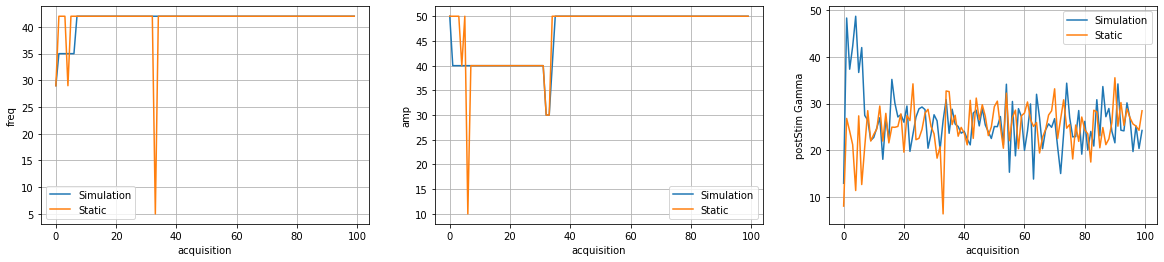

In [27]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [28]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[42. 42. 42. 29. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.  5. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42.]
[50. 50. 50. 40. 50. 10. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 30. 30. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50.]


In [29]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[26.82596445]
 [24.09345256]
 [21.18262912]
 [11.36376666]
 [27.37795958]
 [12.64495395]
 [20.72550903]
 [28.49086317]
 [21.97413158]]


### 1.4: Dynamic BaO

In [30]:
dynamic_model = state_dr_gp()

In [31]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [32]:
U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [33]:
ker_BaO_dynamic = GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
# GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [34]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [35]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0001   1.215820e+03   9.256350e+04 
    00s19  0005   3.367571e+02   7.616892e+02 
    01s19  0049   7.543287e+01   4.601197e-11 
Runtime:     01s19
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926d96250>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c926d8cfa0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926ecca90>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2c926eccf70>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2c926eccdc0>]}

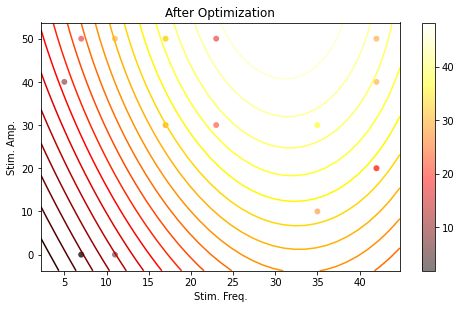

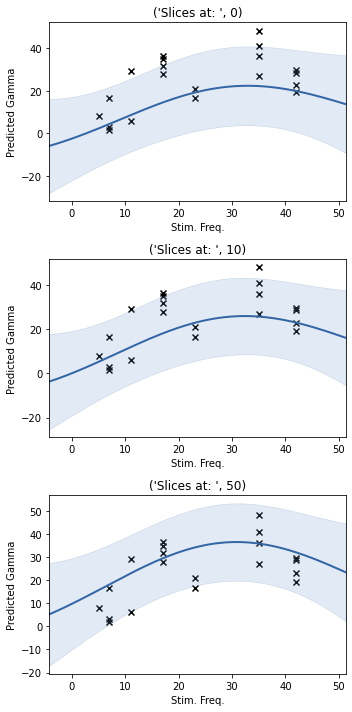

In [36]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [37]:
print(np.shape(testX))

(2500, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [38]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)

    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_samples_to_remember-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_samples_to_remember),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic
    

In [39]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


In [40]:
# testX[argMax_ucb_dynamic]
print(np.shape(trained_model_BaO_Dynamic))

()


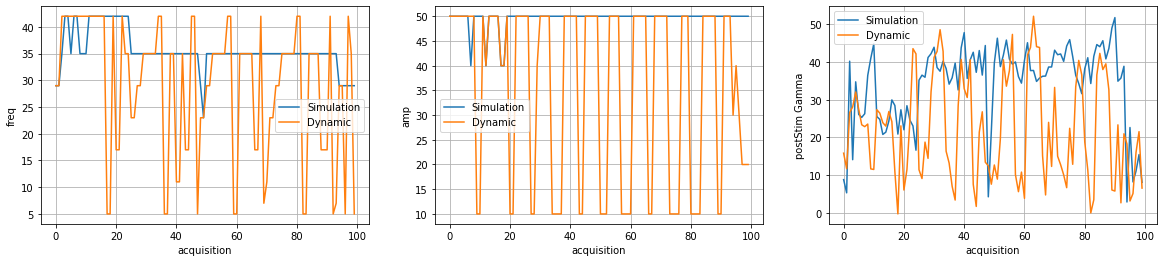

In [41]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c922378820>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2c92277cc10>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2c926d16730>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2c926d16c10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2c926d16d60>]}

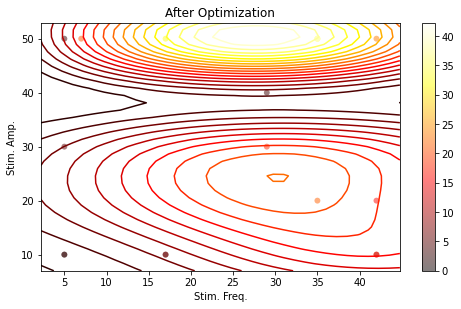

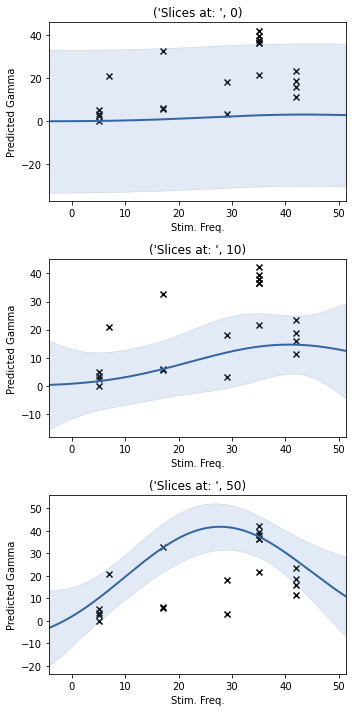

In [42]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: comparing static and dynamic BaO

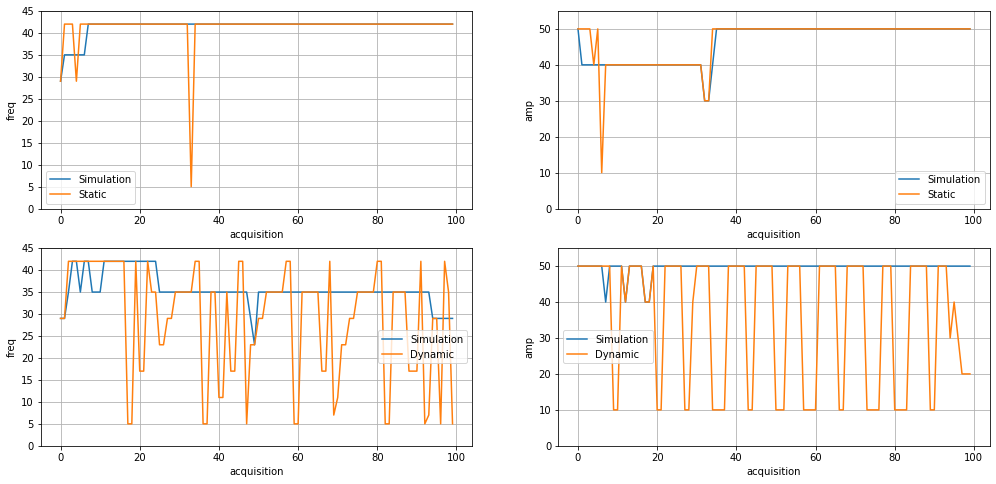

In [43]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.show()


#### 1.5: Experiment Loop 

In [44]:
print(np.shape(model_sample_static))

(100, 3)


In [45]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1.loc[0:n_burn_in-1,:]
    X1_init = X1[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
#     GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
    X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
    # GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e] = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e]  = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.215820e+03   9.256350e+04 
    00s04  0006   2.726962e+02   2.843124e+02 
    00s07  0012   1.012402e+02   2.552124e-01 
    00s11  0018   1.186815e+07   6.336477e+13 
    00s19  0033   7.703033e+01   9.439258e-04 
    00s26  0049   7.543287e+01   4.601197e-11 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.215820e+03   9.256350e+04 
    00s11  0014   8.573819e+01   3.642649e-01  
    00s19  0022   7.833291e+01   3.222963e-04 
    00s31  0049   7.543287e+01   4.601197e-11 
Runtime:     00s31
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


end of run. 
 ----------------------------------------
Experiment run:  1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   4.828655e+02   3.451318e+03 
    00s04  0006   2.726962e+02   2.843124e+02 
    00s08  0013   9.479838e+01   7.928675e-02 
    00s10  0015   8.404619e+01   4.872309e-04 
    00s19  0029   7.590083e+01   2.638376e-03 
    00s19  0030   8.062194e+01   4.695499e-05 
    00s28  0049   7.543287e+01   4.601197e-11 
Runtime:     00s28
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   6.696692e+02   1.086994e+04 
    00s04  0006   2.726962e+02   2.843124e+02 
    00s07  0010   1.234303e+02   2.556954e+00 
    00s10  0015   8.404619e+01   4.872309e-04 
    00s19  0026   7.741717e+01   9.589226e-04 
    00s30  0049   7.543287e+01   4.601197e-11 
Runtime:     00s30
Optimization status: Converged

end of run. 
 ---------------

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide


end of run. 
 ----------------------------------------
Experiment run:  4
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   9.672864e+02   4.097759e+04 
    00s04  0004   4.828655e+02   3.451318e+03 
    00s09  0009   1.414157e+02   7.817440e+00 
    00s16  0013   9.479838e+01   7.928675e-02 
    00s19  0015   8.404619e+01   4.872309e-04 
    00s50  0049   7.543287e+01   4.601197e-11 
Runtime:     00s50
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0005   3.367571e+02   7.616892e+02 
    00s18  0014   8.573819e+01   3.642649e-01 
    00s49  0049   7.543287e+01   4.601197e-11 
Runtime:     00s49
Optimization status: Converged

end of run. 
 ----------------------------------------
Experiment run:  5
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   1.215820e+03   9.256350e+04 
    

##### 1.5.1: plots for Std Dev and Mean

In [46]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)

(100, 3) 
 [[29.         50.          1.52262311]
 [35.         49.          1.54408538]
 [32.6        47.          1.56554764]]
(100, 3) 
 [[29.         50.          1.52262311]
 [42.         50.          1.54408538]
 [37.3        50.          1.56554764]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.00000000e+00 2.22044605e-16]
 [2.93938769e+00 4.58257569e+00 0.00000000e+00]]


In [47]:
# Std Dev bar plots:
std_dev_ucb_df = pd.DataFrame({"Static freq": static_ucb_std[:,0],
                                 "Static amp": static_ucb_std[:,1],
                                 "Dynamic freq": dynamic_ucb_std[:,0],
                                 "Dynamic amp": dynamic_ucb_std[:,1]})
display(std_dev_ucb_df.head())

,Static freq,Static amp,Dynamic freq,Dynamic amp
0,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.0
2,5.139066,0.000000,0.0,0.0
3,5.040833,12.688578,0.0,0.0
4,6.139218,7.483315,0.0,0.0


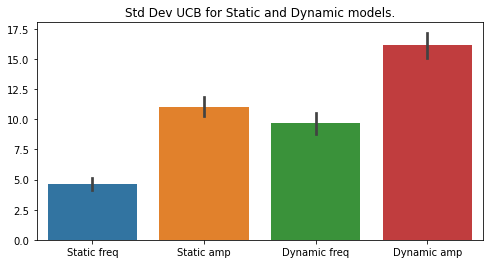

In [48]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static and Dynamic models.");
plt.show();


In [49]:
std_dev_sim_df = pd.DataFrame({"Sim. freq Static": static_sample_std[:,0],
                                 "Sim. amp Static": static_sample_std[:,1],
                                 "Simu. freq Dynamic": dynamic_sample_std[:,0],
                                 "Sim. amp Dynamic": dynamic_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. freq Static,Sim. amp Static,Simu. freq Dynamic,Sim. amp Dynamic
0,0.000000,0.000000,0.000000,0.0
1,0.000000,3.000000,0.000000,0.0
2,2.939388,4.582576,3.429286,0.0
3,4.050926,6.633250,0.000000,3.0
4,2.400000,4.898979,2.100000,0.0


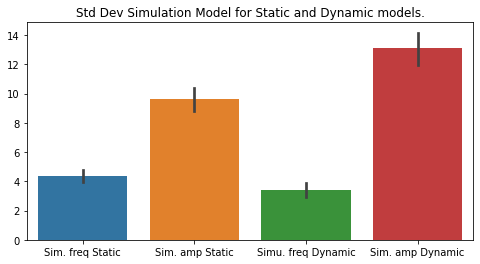

In [50]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev Simulation Model for Static and Dynamic models.");
plt.show();

In [51]:
# Mean UCB:
mean_ucb_df = pd.DataFrame({"Static freq": static_ucb_mean[:,0],
                                 "Static amp": static_ucb_mean[:,1],
                                 "Dynamic freq": dynamic_ucb_mean[:,0],
                                 "Dynamic amp": dynamic_ucb_mean[:,1]})
display(mean_ucb_df.head())

,Static freq,Static amp,Dynamic freq,Dynamic amp
0,29.0,50.0,29.0,50.0
1,42.0,50.0,29.0,50.0
2,37.3,50.0,42.0,50.0
3,35.3,43.0,42.0,50.0
4,36.1,42.0,42.0,50.0


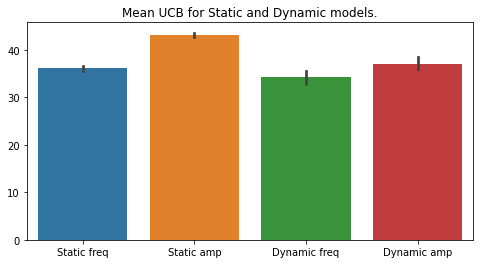

In [52]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_ucb_df); 
plt.title("Mean UCB for Static and Dynamic models.");
plt.show();

In [53]:
# Mean Simulatino Model:
mean_sim_df = pd.DataFrame({"Static freq": static_sample_mean[:,0],
                                 "Static amp": static_sample_mean[:,1],
                                 "Dynamic freq": dynamic_sample_mean[:,0],
                                 "Dynamic amp": dynamic_sample_mean[:,1]})
display(mean_sim_df.head())

,Static freq,Static amp,Dynamic freq,Dynamic amp
0,29.0,50.0,29.0,50.0
1,35.0,49.0,29.0,50.0
2,32.6,47.0,39.2,50.0
3,33.3,44.0,42.0,49.0
4,33.8,44.0,41.3,50.0


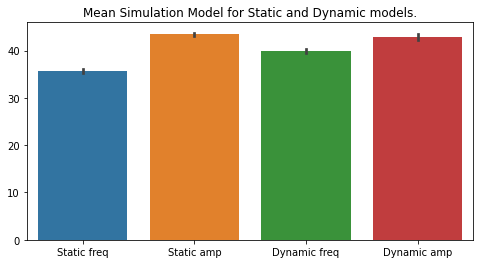

In [54]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_sim_df); 
plt.title("Mean Simulation Model for Static and Dynamic models.");
plt.show();

##### 1.5.2: Acquisition plots

 C:\Users\sinad\AppData\Local\Temp\ipykernel_87508\1342792811.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000002C922A388E0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_87508\1342792811.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000002C922A386A0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_87508\1342792811.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000002C922A209D0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_87508\1342792811.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x000002C922A62610> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_87508\1

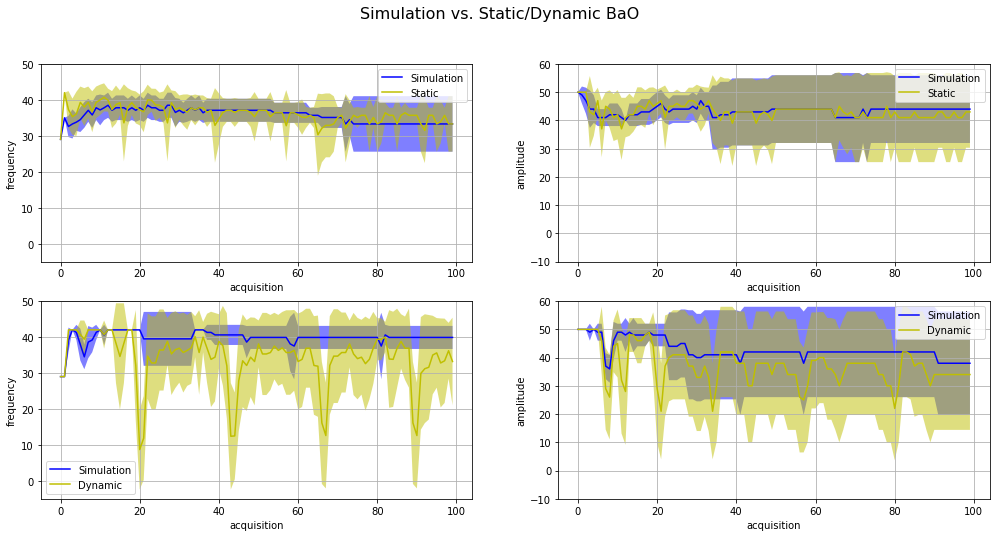

In [55]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO", fontsize=16)
plt.subplot(2,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("frequency")
plt.legend(["Simulation", "_Hidden", "Static", "_Hidden"]);
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("acquisition")
plt.ylabel("amplitude")
plt.legend(["Simulation", '_Hidden', "Static", '_Hidden']);
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("frequency")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden'])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("acquisition")
plt.ylabel("amplitude")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden'])
plt.grid(visible=True)

plt.show();


#### 1.6 Number of samples to converge

In [56]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [13.    4.15 -3.35 -0.6   2.    0.95  0.   -0.65  0.    1.65  0.7  -0.05
 -1.7  -0.6   0.95 -2.55 -0.6   2.8  -0.05 -1.   -0.6   1.4   1.6  -0.7
 -0.7  -0.35 -2.45  0.65  1.85 -0.7  -0.05 -0.6   0.3   0.3   0.    0.3
 -0.65 -0.35 -1.8  -1.2   1.8   1.2   0.3  -0.3   0.    0.3   0.   -0.3
 -0.9   0.3   0.9   0.   -0.9  -0.35  0.55  0.   -1.8   0.    1.8  -0.3
 -0.6  -0.35  0.25  0.   -2.7  -1.5   1.3   0.4   0.2   1.1   1.2  -1.5
 -0.9   1.8   0.6   0.    0.3  -1.2  -0.3   0.   -0.6   1.55  0.9  -0.35
 -1.2   0.    1.55  0.   -0.35  0.   -1.2  -2.1   1.2   2.1  -1.2  -0.9
  1.2  -0.3  -1.2   0.  ] 
 index where static freq plateaus:  (array([ 6,  8, 34, 44, 46, 51, 55, 57, 63, 75, 79, 85, 87, 89, 99],
      dtype=int64),)
The derivative of Static Amp is:  [ 0.   0.  -3.5 -4.   2.  -2.5 -1.   3.5 -2.  -1.  -2.  -0.5  2.5  0.5
  1.5  1.5 -0.5  1.   0.5 -0.5  1.  -2.5 -1.   2.   0.5  0.  -0.5  1.
  1.  -0.5 -1.5 -0.5  1.5 -0.5 -2.5 -2.   0.5  1.5 -2.   0.

In [57]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [  0.     6.5    6.5    0.    -0.65  -1.3    0.65   1.3    0.     0.
  -0.65   0.     0.65  -1.85  -3.7    0.     3.7    1.85  -4.95 -16.65
 -10.1   13.    10.45  -0.95   1.8    1.8    1.2   -0.55  -1.15   0.8
  -0.4   -0.3    0.65   1.9   -0.65  -0.05   0.6   -3.1   -1.25   2.5
   1.6   -3.4  -12.6   -9.75   7.7   10.45   2.15   0.5    0.55   1.85
   1.05  -1.4    0.2    1.1    0.3   -0.25  -0.3   -0.65   0.3   -1.25
  -1.25   1.85   1.55  -2.4   -2.5   -8.    -9.65   8.    11.05   1.3
   0.5    0.5    1.2   -0.2   -2.05  -0.45  -0.7   -0.3    2.2    2.8
   1.2    0.3   -2.75  -3.1    1.5    2.5    0.    -0.95 -10.4  -12.15
   6.9    9.3    0.85   1.9    2.    -1.1   -1.1    1.7   -0.1   -3.  ] 
 index where dynamic freq plateaus:  (array([ 0,  3,  8,  9, 11, 15, 86], dtype=int64),)
The derivative of dynamic Amp is:  [  0.    0.    0.    0.    0.   -2.  -10.5 -10.    7.5   9.5  -6.   -8.5
   8.   10.   -1.   -1.    1.    1.5  -2.  -10.  -11.5   4.  

In [58]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -6.0
the dynamic amp plateaus at sample %d after the static sample. 0.0


In [59]:
print(np.shape(idx_plateau_static_freq),
     np.shape(idx_plateau_static_amp),
     np.shape(idx_plateau_dynamic_freq),
     np.shape(idx_plateau_dynamic_amp))

(15,) (36,) (7,) (34,)


<AxesSubplot:>

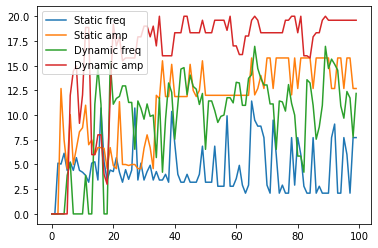

In [60]:
# number of samples to converge:
std_dev_ucb_df.plot.line()

In [61]:
std_dev_ucb_df.describe()

,Static freq,Static amp,Dynamic freq,Dynamic amp
count,100.000000,100.000000,100.000000,100.000000
mean,4.609218,11.041224,9.681636,16.152264
std,2.457582,4.180447,4.640667,5.394008
min,0.000000,0.000000,0.000000,0.000000
25%,2.913760,7.362486,7.560423,16.000000
50%,4.006245,12.000000,11.113497,18.330303
75%,5.771607,15.132746,12.913927,19.595918
max,11.419720,15.779734,16.955530,20.000000


In [62]:
std_dev_static_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Static freq']<std_dev_ucb_df['Static freq'].mean(),['Static freq']].index
std_dev_static_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Static amp']<std_dev_ucb_df['Static amp'].mean(),['Static amp']].index

std_dev_dynamic_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Dynamic freq']<std_dev_ucb_df['Dynamic freq'].mean(),['Dynamic freq']].index
std_dev_dynamic_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Dynamic amp']<std_dev_ucb_df['Dynamic amp'].mean(),['Dynamic amp']].index
print('std_dev_static_freq_converge \n', std_dev_static_freq_converge)
print('std_dev_static_amp_converge \n', std_dev_static_amp_converge)
print('std_dev_dynamic_freq_converge \n', std_dev_dynamic_freq_converge)
print('std_dev_dynamic_amp_converge \n', std_dev_dynamic_amp_converge)

std_dev_static_freq_converge 
 Int64Index([ 0,  1,  5,  7,  9, 10, 11, 12, 15, 18, 19, 20, 22, 23, 24, 25, 26,
            28, 30, 31, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48,
            50, 51, 52, 54, 55, 56, 58, 59, 60, 62, 63, 64, 70, 71, 74, 75, 76,
            77, 79, 82, 83, 84, 86, 87, 88, 89, 90, 93, 94, 97],
           dtype='int64')
std_dev_static_amp_converge 
 Int64Index([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
           dtype='int64')
std_dev_dynamic_freq_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 17, 18, 27,
            30, 34, 36, 37, 40, 50, 54, 73, 80, 81, 82, 86, 87, 98],
           dtype='int64')
std_dev_dynamic_amp_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18,
            19, 23, 24, 25, 26, 27, 36, 37, 38, 39, 61, 62, 82, 83, 84],
           dtype='int64')


In [63]:
print(np.shape(std_dev_static_freq_converge),
     np.shape(std_dev_static_amp_converge),
     np.shape(std_dev_dynamic_freq_converge),
     np.shape(std_dev_dynamic_amp_converge))

(64,) (32,) (31,) (32,)


#### 1.5.2: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [64]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0031
nmse_static_simulatinon_amp:  0.0024 

nmse_dynamic_simulatinon_freq:  0.0522
nmse_dynamic_simulatinon_amp:  0.0714


In [65]:
print(np.shape(static_ucb_std))

(100, 3)


In [66]:
# Post stimulation Gamma comparison plots

postStim_gamma_df = pd.DataFrame({"Simulation S": simulation_postStimGamma_predicted.flatten('C'),
                                 "Static": static_postStimGamma_predicted.flatten('C'),
                                 "Simulation D": simulation_postStimGamma_predicted_d.flatten('C'),
                                 "Dynamic": dynamic_postStimGamma_predicted.flatten('C')})
postStim_gamma_df.head()

,Simulation S,Static,Simulation D,Dynamic
0,16.154538,14.543328,18.562471,21.097269
1,15.021758,13.137582,14.161994,5.588224
2,9.740798,13.209883,13.106349,4.469015
3,9.926117,14.605822,15.518479,12.398355
4,12.391682,13.068137,15.539164,10.265293


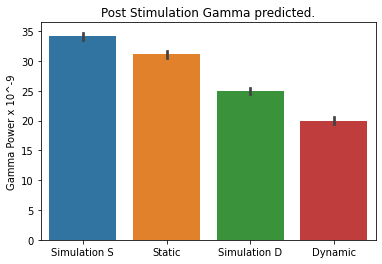

In [67]:
sns.barplot(data=postStim_gamma_df);
plt.ylabel("Gamma Power x 10^-9");
plt.title("Post Stimulation Gamma predicted.");
plt.show();

#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end